In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import us

In [2]:
spending = pd.read_excel('data/IIJA FUNDING AS OF MARCH 2023.xlsx', engine = 'openpyxl', names=['area','spending'])

In [3]:
print(
    spending.head(),
    spending.tail()
)

             area  spending
0         ALABAMA    3.0000
1          ALASKA    3.7000
2  AMERICAN SAMOA    0.0686
3         ARIZONA    3.5000
4        ARKANSAS    2.8000              area  spending
52       VIRGINIA       4.5
53     WASHINGTON       4.0
54  WEST VIRGINIA       2.0
55      WISCONSIN       2.8
56        WYOMING       2.3


In [4]:
population = pd.read_excel('https://www2.census.gov/programs-surveys/popest/tables/2020-2023/state/totals/NST-EST2023-POP.xlsx', engine='openpyxl', header=3)
population.head()

,Unnamed: 0,Unnamed: 1,2020,2021,2022,2023
0,United States,331464948.0,331526933.0,332048977.0,333271411.0,334914895.0
1,Northeast,57614141.0,57430477.0,57243423.0,57026847.0,56983517.0
2,Midwest,68987296.0,68969794.0,68850246.0,68783028.0,68909283.0
3,South,126268529.0,126465281.0,127353282.0,128702030.0,130125290.0
4,West,78594982.0,78661381.0,78602026.0,78759506.0,78896805.0


In [5]:
population.columns = ['area', 'pop_base', 'pop2020', 'pop2021', 'pop2022', 'pop2023']
population.head(10)

,area,pop_base,pop2020,pop2021,pop2022,pop2023
0,United States,331464948.0,331526933.0,332048977.0,333271411.0,334914895.0
1,Northeast,57614141.0,57430477.0,57243423.0,57026847.0,56983517.0
2,Midwest,68987296.0,68969794.0,68850246.0,68783028.0,68909283.0
3,South,126268529.0,126465281.0,127353282.0,128702030.0,130125290.0
4,West,78594982.0,78661381.0,78602026.0,78759506.0,78896805.0
5,.Alabama,5024294.0,5031864.0,5050380.0,5073903.0,5108468.0
6,.Alaska,733374.0,732964.0,734923.0,733276.0,733406.0
7,.Arizona,7157902.0,7186683.0,7272487.0,7365684.0,7431344.0
8,.Arkansas,3011490.0,3014348.0,3028443.0,3046404.0,3067732.0
9,.California,39538212.0,39503200.0,39145060.0,39040616.0,38965193.0


In [6]:
population.area = population.area.str.replace('.', '')
population.head(10)

,area,pop_base,pop2020,pop2021,pop2022,pop2023
0,United States,331464948.0,331526933.0,332048977.0,333271411.0,334914895.0
1,Northeast,57614141.0,57430477.0,57243423.0,57026847.0,56983517.0
2,Midwest,68987296.0,68969794.0,68850246.0,68783028.0,68909283.0
3,South,126268529.0,126465281.0,127353282.0,128702030.0,130125290.0
4,West,78594982.0,78661381.0,78602026.0,78759506.0,78896805.0
5,Alabama,5024294.0,5031864.0,5050380.0,5073903.0,5108468.0
6,Alaska,733374.0,732964.0,734923.0,733276.0,733406.0
7,Arizona,7157902.0,7186683.0,7272487.0,7365684.0,7431344.0
8,Arkansas,3011490.0,3014348.0,3028443.0,3046404.0,3067732.0
9,California,39538212.0,39503200.0,39145060.0,39040616.0,38965193.0


In [7]:
population = population.dropna(axis=0, how='any')
population.tail(10)

,area,pop_base,pop2020,pop2021,pop2022,pop2023
47,Tennessee,6910786.0,6926091.0,6963709.0,7048976.0,7126489.0
48,Texas,29145459.0,29234361.0,29561286.0,30029848.0,30503301.0
49,Utah,3271614.0,3283982.0,3339284.0,3381236.0,3417734.0
50,Vermont,643077.0,642936.0,647093.0,647110.0,647464.0
51,Virginia,8631373.0,8637193.0,8657348.0,8679099.0,8715698.0
52,Washington,7705267.0,7724566.0,7741433.0,7784477.0,7812880.0
53,West Virginia,1793713.0,1791562.0,1785249.0,1774035.0,1770071.0
54,Wisconsin,5893713.0,5896700.0,5879978.0,5890543.0,5910955.0
55,Wyoming,576850.0,577664.0,579548.0,581629.0,584057.0
57,Puerto Rico,3285874.0,3281557.0,3262693.0,3220113.0,3205691.0


In [8]:
population.area = population.area.str.lower()
spending.area = spending.area.str.lower()

In [9]:
print(
    population.area[~population.area.isin(spending.area)],
    spending.area[~spending.area.isin(population.area)]
)

0     united states
1         northeast
2           midwest
3             south
4              west
12         delaware
Name: area, dtype: object 2               american samoa
8                     deleware
12                        guam
37    northern mariana islands
48          tribal communities
49           us virgin islands
Name: area, dtype: object


In [10]:
spending.loc[spending.area == 'deleware', 'area'] = 'delaware'

In [11]:
data = pd.merge(population, spending, on='area', how='inner')

In [12]:
data[data.pop2023.isnull()]

,area,pop_base,pop2020,pop2021,pop2022,pop2023,spending


In [13]:
print(
    data.head(),
    f'\n\nShape: {data.shape}'
)

         area    pop_base     pop2020     pop2021     pop2022     pop2023  \
0     alabama   5024294.0   5031864.0   5050380.0   5073903.0   5108468.0   
1      alaska    733374.0    732964.0    734923.0    733276.0    733406.0   
2     arizona   7157902.0   7186683.0   7272487.0   7365684.0   7431344.0   
3    arkansas   3011490.0   3014348.0   3028443.0   3046404.0   3067732.0   
4  california  39538212.0  39503200.0  39145060.0  39040616.0  38965193.0   

   spending  
0       3.0  
1       3.7  
2       3.5  
3       2.8  
4      18.4   

Shape: (52, 7)


In [15]:
data['spending_per_capita'] = (data['spending'] * 10**9) / data['pop2023']

In [22]:
mapping = us.states.mapping('name', 'abbr')
mapping = {key.lower(): value for key, value in mapping.items()}
mapping

{'alabama': 'AL',
 'alaska': 'AK',
 'arizona': 'AZ',
 'arkansas': 'AR',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'delaware': 'DE',
 'florida': 'FL',
 'georgia': 'GA',
 'hawaii': 'HI',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'iowa': 'IA',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'maine': 'ME',
 'maryland': 'MD',
 'massachusetts': 'MA',
 'michigan': 'MI',
 'minnesota': 'MN',
 'mississippi': 'MS',
 'missouri': 'MO',
 'montana': 'MT',
 'nebraska': 'NE',
 'nevada': 'NV',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'new york': 'NY',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'pennsylvania': 'PA',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south dakota': 'SD',
 'tennessee': 'TN',
 'texas': 'TX',
 'utah': 'UT',
 'vermont': 'VT',
 'virginia': 'VA',
 'washington': 'WA',
 'west virginia': 'WV',
 'wisconsin': 'WI',
 'wyoming': 'WY',
 'american samoa': 'AS',
 'g

In [27]:
data['area_abbr'] = data['area'].map(mapping)
data.loc[data.area_abbr.isnull(), 'area_abbr'] = 'DC'

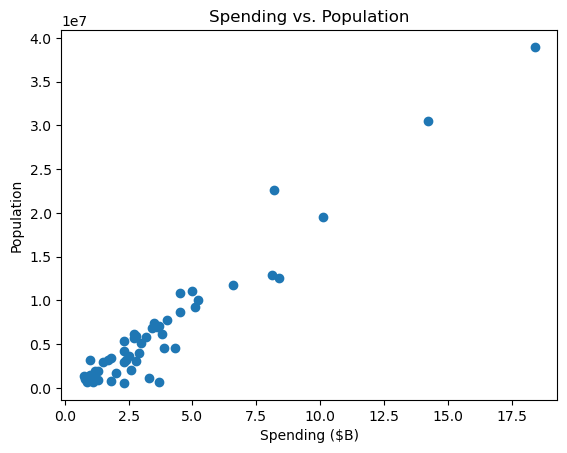

In [35]:
fig, ax = plt.subplots()
ax.scatter(data.spending, data.pop2023)
ax.set_xlabel('Spending ($B)')
ax.set_ylabel('Population')
ax.set_title('Spending vs. Population')
plt.show()

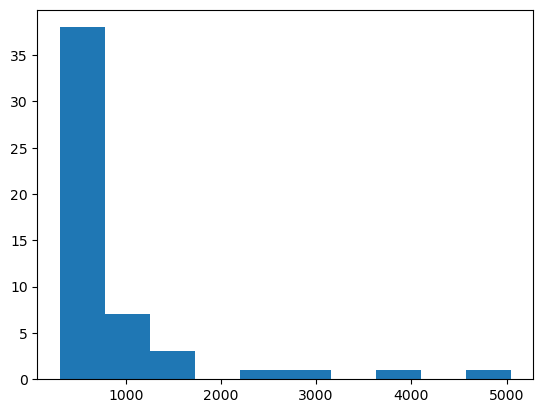

In [30]:
fig, ax = plt.subplots()
ax.hist(data.spending_per_capita)
plt.show()

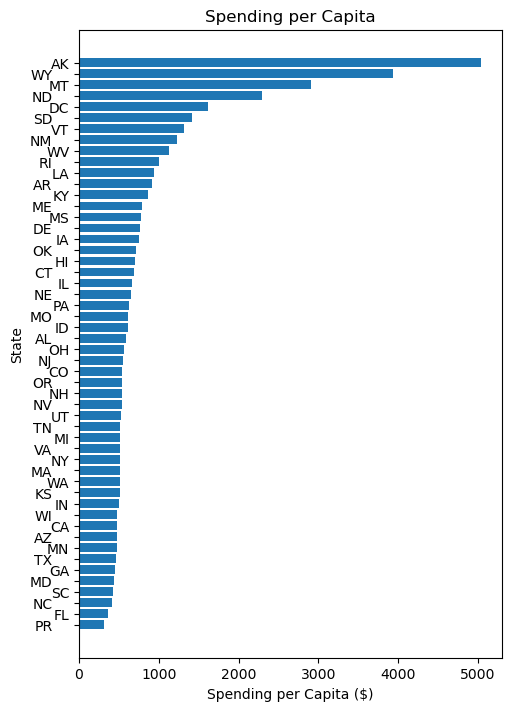

In [60]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
ax.barh('area_abbr', 'spending_per_capita', data = data.sort_values(by = 'spending_per_capita'))
ax.set_title('Spending per Capita')
ax.set_xlabel('Spending per Capita ($)')
ax.set_ylabel('State')

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.04, 0))

plt.show()

In [62]:
import pandas as pd

# Data for state-wise party affiliation based on the 2020 presidential election results.
# States are categorized as 'Red' (Republican), 'Blue' (Democrat), or 'Purple' (Swing).
# This data is a simplified representation and might not reflect the complete political dynamics.
state_party_dict = {
    'State': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
              'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
              'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
              'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
              'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
              'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
              'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'Party': ['Red', 'Red', 'Blue', 'Red', 'Blue',
              'Blue', 'Blue', 'Blue', 'Red', 'Blue',
              'Blue', 'Red', 'Blue', 'Red', 'Red',
              'Red', 'Red', 'Red', 'Blue', 'Blue',
              'Blue', 'Blue', 'Blue', 'Red', 'Red',
              'Red', 'Red', 'Blue', 'Blue', 'Blue',
              'Blue', 'Blue', 'Red', 'Red', 'Red',
              'Red', 'Blue', 'Blue', 'Blue', 'Red',
              'Red', 'Red', 'Red', 'Red', 'Blue',
              'Blue', 'Blue', 'Red', 'Blue', 'Red']
}

# Create a DataFrame
state_party_df = pd.DataFrame(state_party_dict)

# Display the DataFrame
state_party_df.head()

# Defining swing states based on the 2020 election results
swing_states = ['Arizona', 'Florida', 'Georgia', 'Michigan', 'Nevada', 'New Hampshire', 'North Carolina', 'Pennsylvania', 'Wisconsin']

# Update the 'Party' column to include swing states
state_party_df['Party'] = state_party_df.apply(lambda row: 'Purple' if row['State'] in swing_states else row['Party'], axis=1)

# Display the updated DataFrame
state_party_df


,State,Party
0,Alabama,Red
1,Alaska,Red
2,Arizona,Purple
3,Arkansas,Red
4,California,Blue
5,Colorado,Blue
6,Connecticut,Blue
7,Delaware,Blue
8,Florida,Purple
9,Georgia,Purple
